# Lib

In [1]:
import seaborn as sns 
import matplotlib.pyplot as plt 
import torch 
import numpy as np 
import glob 
import os 
import io 
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import matplotlib
import pandas as pd 
# plt.style.use('seaborn-v0_8-darkgrid'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def check_data(data):
    for k,v in data.items():
        if isinstance(v,np.ndarray):
            print(k,v.shape)
        else:
            try:
                print(k, 'Length: ', len(v))
            except:
                print(k, v)

def load_data(path):
    data = np.load(path,allow_pickle=True).item()
    return data 

# Func


In [3]:
def parse_dir(path):
    list_data_path = []
    for p in glob.glob(path+'/*.npy'):
        list_data_path.append(p)
    return sorted(list_data_path)

In [4]:
def get_eval_data(path):
    data = load_data(path)
    res = {}
    name = data['name']
    n_agent = len(data['first_done']) 
    res['eval_name'] = name

    list_stability, list_tracking_error, list_path_length = [], [], []
    list_fall_rate = []
    for i in range(n_agent):
        first_done = data['first_done'][i]
        tracking_error = data['tracking_error'][i]
        list_path_length.append(first_done)
        list_fall_rate.append(data['Fall'][i])

        vel_roll = data['base_vel_roll'][i][0: first_done]
        vel_pitch = data['base_vel_pitch'][i][0: first_done]
        stability = np.sqrt(np.square(vel_roll) + np.square(vel_pitch))
        list_stability.append(np.mean(stability))
        list_tracking_error.append(np.mean(tracking_error[0: first_done]))

    list_stability = np.array(list_stability)
    list_tracking_error = np.array(list_tracking_error)
    list_path_length = np.array(list_path_length)
    list_fall_rate = np.array(list_fall_rate)
    res['stability'] = list_stability
    res['tracking_error'] = list_tracking_error
    res['path_length'] = list_path_length
    res['fall_rate'] = list_fall_rate
    return res  
    
def get_df(list_data:list):
    list_df = []
    for data in list_data:
        df = pd.DataFrame(data)
        df['name'] = data['eval_name']
        list_df.append(df) 
    df = pd.concat(list_df) 
    return df

# 分布内泛化测试

In [88]:
def prepare_single_force_data(list_data_path:list , list_data_name: list, force_val = 50):
    list_data = [get_eval_data(data_path) for data_path in list_data_path]
    list_df = []
    for i,data in enumerate(list_data):
        df = pd.DataFrame(data)
        df['name'] = list_data_name[i]
        df['force'] = force_val
        list_df.append(df)
    df = pd.concat(list_df)
    return df 

def plot_iid_test(df, y_name, x_name, hue_name, save_path, y_label, x_label, title, ylim=None, xlim=None, 
                  remove_outliers = False,
                  plot_type = 'box',
                  title_fontsize=22, label_fontsize=22, legend_fontsize=14, legend_location='upper right'):
    if remove_outliers:
        Q1 = df[y_name].quantile(0.25)
        Q3 = df[y_name].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[y_name] < (Q1 - 1.5 * IQR)) |(df[y_name] > (Q3 + 1.5 * IQR)))]

    fig, ax = plt.subplots(figsize=(12,8))
    sns.set_style("darkgrid")
    if plot_type == 'box':
        box = sns.boxplot(data=df, x=x_name, y=y_name, hue=hue_name, ax=ax)
    elif plot_type == 'bar':
        box = sns.barplot(data=df, x=x_name, y=y_name, hue=hue_name, ax=ax)
    
    ax.set_ylabel(y_label, fontsize=label_fontsize)
    ax.set_xlabel(x_label, fontsize=label_fontsize)
    ax.set_title(title, fontsize=title_fontsize)
    
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None:
        ax.set_xlim(xlim)
    
    plt.legend(bbox_to_anchor=(1.15, 0.8), loc=legend_location, borderaxespad=0., fontsize=legend_fontsize)
    
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [76]:
list_data_name = ['PPO','PPO1','RMA','RMA1']

In [77]:

force_values = [10, 20, 30, 40]
dfs = []

for force in force_values:
    paths = parse_dir(f"logs/Eval/iid/v05/{force}N")
    df = prepare_single_force_data(paths, list_data_name, force_val=force)
    dfs.append(df)

df = pd.concat(dfs)

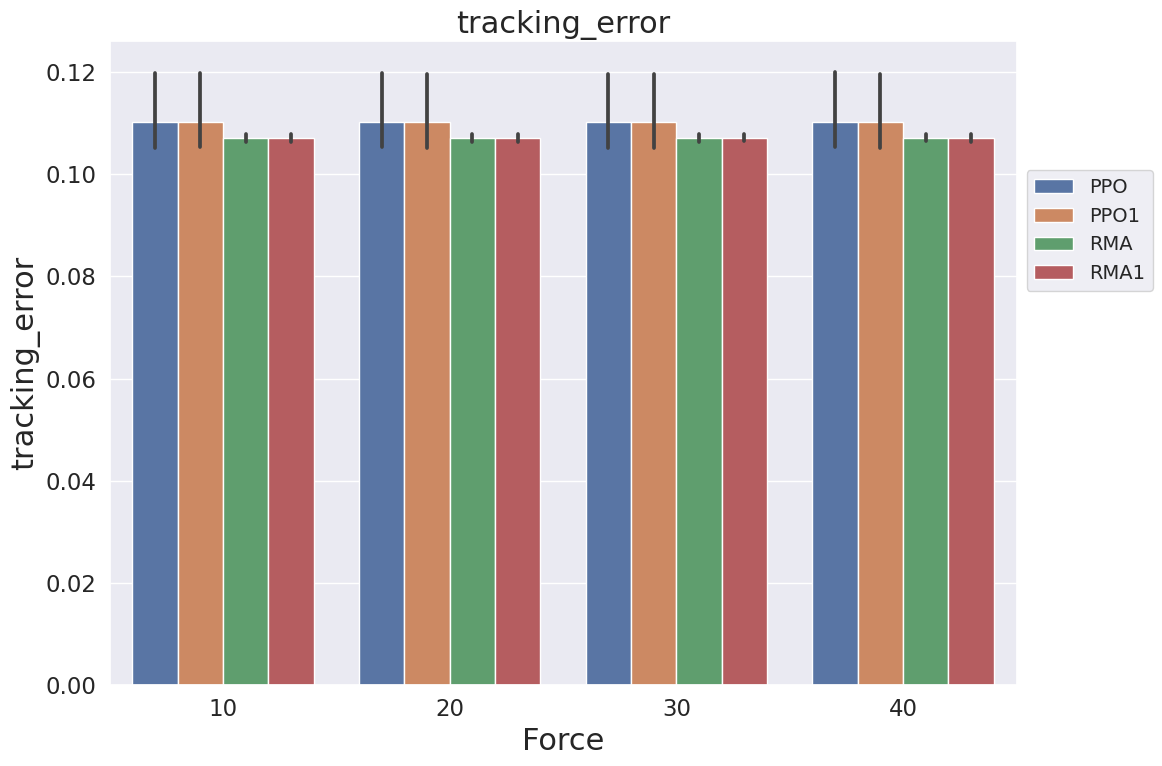

In [89]:
plot_iid_test(df, y_name='tracking_error', x_name='force', 
              hue_name='name', save_path=None, y_label='tracking_error',
              x_label='Force', title='tracking_error',
              remove_outliers=False,
              plot_type='bar')

# 组合泛化测试 

# 步态分析

In [70]:
def get_contact_data(path, 
                     start_step = 0, end_step = 500,
                     agent_id = 0,force_threshold = 1):
    data = load_data(path)
    res = {}
    name = data['name']
    n_agent = len(data['first_done']) 
    res['eval_name'] = name
    applied_force = data['force'][0] # shape = (n_step, n_body, 3)
    n_body_force = np.abs(applied_force).sum(-1) # shape = (n_step,n_body)
    n_step_count = ( n_body_force > 0 ).sum(-1) # shape = (n_step)
    n_force = np.max(n_step_count) 
    print("N force ", n_force) 

    i = agent_id
    first_done = data['first_done'][i]
    contact_force_z = data['contact_force_z'][i][0: first_done]
    applied_force = data['force'][i][0: first_done]
    base_vel = data['base_vel'][i][0: first_done]
    base_vel_roll = data['base_vel_roll'][i][0: first_done]
    body_index = []
    for i in range(first_done):
        f = np.abs(applied_force[i]).sum(-1) # (n_body,3)
        body_index.append(np.argwhere(f > 0).reshape(-1))
    body_index = np.concatenate(body_index,axis=0) # (n_step, n_body)
    contacts = np.where(contact_force_z > force_threshold, 1.0, 0.0) # (n_step,4)
    force_change_points = np.where(np.abs(np.diff(np.abs(applied_force))).sum((-1,-2)) > 0.1, 1.0, 0.0)

    res['base_vel_x'] = base_vel[start_step:end_step,0]
    res['base_vel_y'] = base_vel[start_step:end_step,1]
    res['base_vel_z'] = base_vel[start_step:end_step,2]
    res['base_vel_roll'] = base_vel_roll[start_step:end_step]
    res['contact'] = contacts[start_step:end_step]
    res['force'] = applied_force[start_step:end_step]
    res['body_index'] = body_index[start_step:end_step]
    res['change_points'] = force_change_points

    selected_force = []
    for j in range(res['body_index'].shape[0]):
        index = body_index[j]
        selected_force.append(res['force'][j,index])
    selected_force = np.array(selected_force)
    res['applied_force'] = selected_force
    return res  

def prepare_sequential_data(list_data_path, start_step = 0, end_step = 500, agent_id = 0, force_threshold = 1):
    list_vel_x, list_vel_z, list_vel_roll = [],[],[]    
    for i in range(len(list_data_path)):
        data = get_contact_data(list_data_path[i], start_step = start_step, end_step = end_step, agent_id = agent_id, force_threshold = force_threshold) 
        list_vel_x.append(data['base_vel_x'])
        list_vel_z.append(data['base_vel_z'])
        list_vel_roll.append(data['base_vel_roll'])
        change_points = data['change_points']

    return list_vel_x, list_vel_z, list_vel_roll,change_points

        


In [54]:


def sequential_compare(
        list_vel_x, list_vel_z, list_vel_roll,list_name, start_step, change_points, dt=0.02,
                    title=None, title_fontsize=12, xlabel_fontsize=12, ylabel_fontsize=12,
                    save_path=None, subplot_spacing=0.4,xtick_fontsize = 12,
                    save_name = 'SequentialCompare'):
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(3, 1, figsize=(8, 4), sharex=True)
    n_step = list_vel_x[0].shape[0]
    time = (np.arange(n_step) + start_step) * dt
    #! vel_x
    for name,vel in zip(list_name,list_vel_x):
        axs[0].plot(time, vel, label=name,linewidth = 1,alpha = 0.8)
    for change_point in change_points:
        if change_point:
            axs[0].axvline((change_point + start_step) * dt, color='tab:red', linestyle='dashed')
        # axs[0].axvline(change_point * dt, color='tab:red', linestyle='dashed')
    axs[0].set_ylabel(r'$\dot{x}$', fontsize=ylabel_fontsize)
    axs[0].set_ylim([-0.2, 1.5])
    # axs[0].grid()
    axs[0].legend(frameon=True,loc=2, bbox_to_anchor=(1.01,-0.4),borderaxespad = 0.,fontsize = 10)
    axs[0].tick_params(axis='both', labelsize=xtick_fontsize)
    #! vel_z 
    for name, data in zip(list_name,list_vel_z):
        axs[1].plot(time, data, label=name,linewidth = 1,alpha = 0.8)
    axs[1].set_ylabel(r'$\dot{z}$', fontsize=ylabel_fontsize)
    axs[1].tick_params(axis='both', labelsize=xtick_fontsize)
    # axs[1].grid()

    # axs[1].legend_.remove()
    for change_point in change_points:
        if change_point:
            axs[1].axvline((change_point + start_step) * dt, color='tab:red', linestyle='dashed')

    #! vel_roll
    for name, data in zip(list_name,list_vel_roll):
        axs[2].plot(time, data, label=name,linewidth = 1,alpha = 0.8)
    axs[2].set_ylabel(r'$\theta_r$', fontsize=ylabel_fontsize)
    # axs[2].grid()
    # axs[2].legend_.remove()
    for change_point in change_points:
        if change_point :
            axs[2].axvline((change_point + start_step) * dt, color='tab:red', linestyle='dashed')
    axs[2].tick_params(axis='both', labelsize=xtick_fontsize)
    axs[-1].set_xlabel('Time (s)',fontsize = xlabel_fontsize)
    # Set plot title with fontsize
    if title:
        plt.suptitle(title, fontsize=title_fontsize)

    plt.tight_layout()
    # plt.legend(frameon=True)
    # Adjust subplot spacing
    plt.subplots_adjust(hspace=subplot_spacing)

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path + f'/{save_name}.pdf', bbox_inches='tight')
    else:
        plt.show()

In [78]:
def visualize_legged_robot_contacts(contacts, args=['FL', 'FR', 'RL', 'RR'],change_points = None,start_step =0,
                                    xlim=None, title=None,
                                    title_fontsize=20, dt=0.02,xlabel_fontsize=20,ylabel_fontsize=20,xtick_fontsize=18,
                                    y_spacing=0.2, save_path=None,save_name = 'ContactState', filter_window_size=None):
    # Create a new figure
    # sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=(16,3))
    start_time = start_step * dt
    n_step = contacts.shape[0]
    # Define a colormap for leg colors
    leg_colors = {
        'FL': 'r',
        'FR': 'b',
        'RL': 'g',
        'RR': 'grey'
    }

    y_positions = {}  # Dictionary to store y-positions for each leg
    for leg in args:
        y_positions[leg] = y_spacing * (args.index(leg) + 1)

    for leg in args:
        leg_contact = contacts[:, args.index(leg)]  # Extract contact values for the leg

        color = leg_colors.get(leg, 'gray')  # Use gray color if leg name not found

        # Plot contact values as horizontal bars
        for t in range(len(leg_contact)):
            if leg_contact[t] == 1:
                ax.plot([t * dt + start_time, (t + 1) * dt + start_time], [y_positions[leg], y_positions[leg]], color=color, lw=20)
            else:
                ax.plot([t * dt + start_time, (t + 1) * dt + start_time], [y_positions[leg], y_positions[leg]], color='white', lw=20)
    if change_points is not None:
        for change_point in change_points:
            # if change_point > start_step and change_point <( start_step + n_step):
             ax.axvline(change_point * dt + start_time, color='tab:red', linestyle='dashed')
            # ax.axvline(change_point * dt, color='tab:red', linestyle='dashed')
    # Set y-axis labels and remove y-axis ticks
    ax.set_yticks(list(y_positions.values()))
    ax.set_yticklabels(args, fontsize=ylabel_fontsize)
    ax.set_ylabel("Contact State", fontsize=ylabel_fontsize)
    # Set x-axis label and limits
    ax.set_xlabel("Time(s)", fontsize=xlabel_fontsize)
    if xlim is not None:
        ax.set_xlim(xlim)

    ax.tick_params(axis='both', labelsize=xtick_fontsize)
    # Set overall figure title
    if title is not None:
        fig.suptitle(title, fontsize=title_fontsize, y=0.95)

    # Remove unnecessary spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)

    # Show or save the figure
    if save_path is not None:
        plt.savefig(save_path + f'/{save_name}.pdf', bbox_inches='tight')
    else:
        plt.show()

def visualize_force_applied( body_index, applied_force, change_points, start_point,plot_index = True):
    fig, axs = plt.subplots(1, 1, figsize=(12, 4), sharex=True)
    n_step = applied_force.shape[0]
    time = (np.arange(n_step) + start_point) * 0.02
    applied_force_norm = np.linalg.norm(applied_force, axis=-1)
    if len(body_index.shape) == 1:
        body_index = body_index.reshape(-1,1)
    n_body = body_index.shape[-1]
    if plot_index:
        for i in range(n_body):
            axs.scatter(time,body_index[:,i])
            axs.set_ylabel('Body Index')
    else:
        for i in range(n_body):
            axs.plot(time,applied_force[:,i],label = f'Body {i}')
            axs.set_ylabel('Force')
    axs.set_xlabel('Time (s)')
    for change_point in change_points:
        if change_point > start_point and change_point <( start_point + n_step):
            axs.axvline(change_point * 0.02, color='tab:red', linestyle='dashed')
            # axs[0].axvline(change_point * 0.02, color='tab:red', linestyle='dashed')
    plt.show()

In [79]:
res = get_contact_data("logs/Eval/iid/v05/40N/Expert-PushBaseline-stationary_push-expert-DebugEval copy.npy",
                       start_step=200,end_step=800)

N force  1


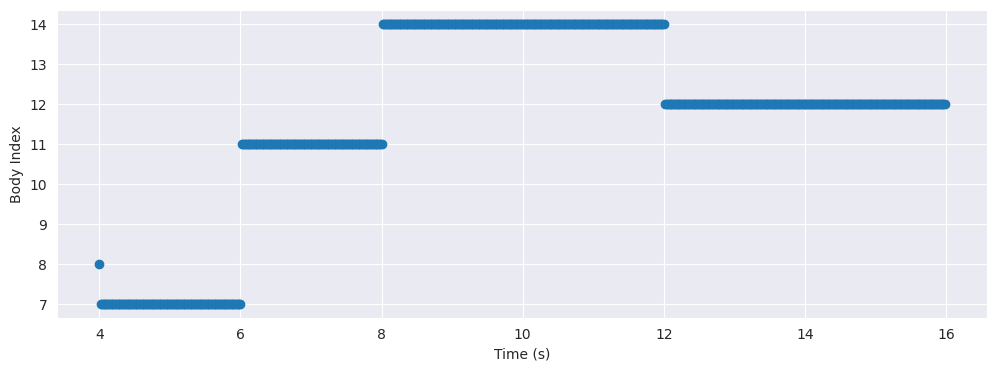

In [80]:
visualize_force_applied(res['body_index'],
                        res['applied_force'],
                        res['change_points'],
                        start_point=200,
                        plot_index=True)

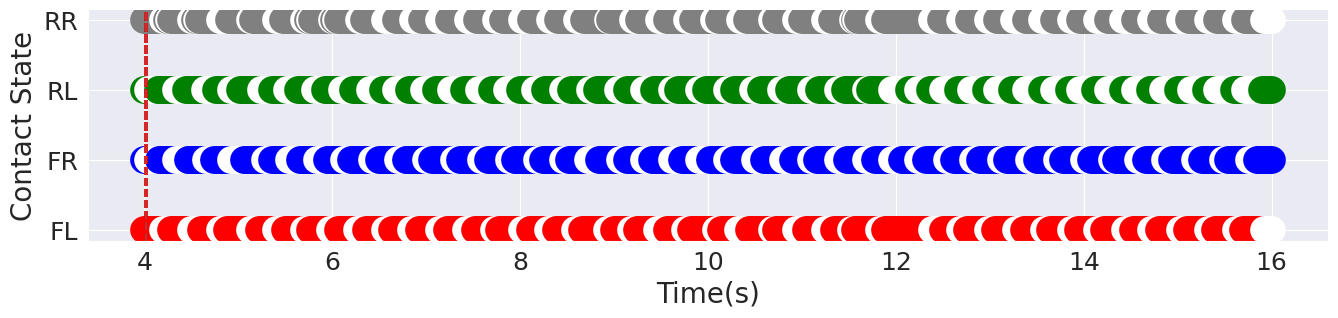

In [28]:
visualize_legged_robot_contacts(
    contacts = res['contact'],
    change_points= res['change_points'],
    start_step=200,
)

In [41]:
list_path = parse_dir("logs/Eval/iid/v05/40N")
list_data_name = ['PPO','PPO1','RMA','RMA1']

In [68]:
list_vel_x, list_vel_z, list_vel_roll,change_points,list_body_force = prepare_sequential_data(list_path,
                                                                              start_step=200,
                                                                              end_step=220,
                                                                              agent_id=0,
                                                                              force_threshold=1)

N force  1
[8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
(20,) [49.99991  0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.     ]
N force  1
[8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
(20,) [ 0.      49.99991 49.99991 49.99991 49.99991 49.99991 49.99991 49.99991
 49.99991 49.99991 49.99991 49.99991 49.99991 49.99991 49.99991 49.99991
 49.99991 49.99991 49.99991 49.99991]
N force  1
[0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
(20,) [ 0.      49.99976 49.99976 49.99976 49.99976 49.99976 49.99976 49.99976
 49.99976 49.99976 49.99976 49.99976 49.99976 49.99976 49.99976 49.99976
 49.99976 49.99976 49.99976 49.99976]
N force  1
[0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
(20,) [ 0.       49.999756 49.999756 49.999756 49.999756 49.999756 49.999756
 49.999756 49.999756 49.999756 49.999756 49.999756 49.999756 49.999756
 49.999756 49.999756 49.999756 49.999756 49.999756 49.999756]


In [62]:
list_body_force[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

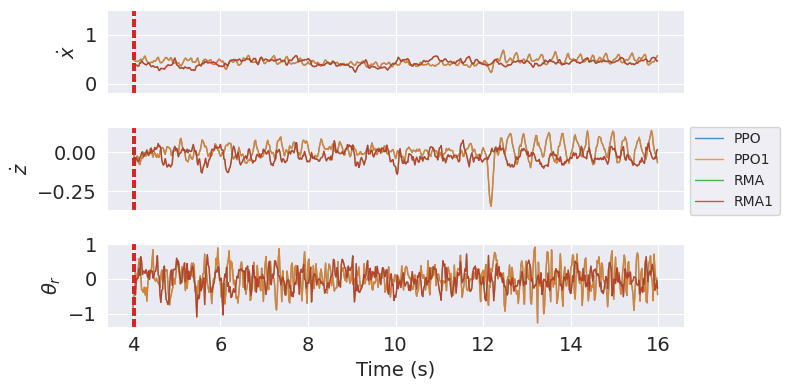

In [55]:
sequential_compare(
    list_vel_x, list_vel_z, list_vel_roll,list_data_name, start_step=200, change_points=change_points,
    title=None, title_fontsize=14, xlabel_fontsize=14, ylabel_fontsize=14,
    save_path=None, subplot_spacing=0.4,xtick_fontsize = 14,
    save_name = 'SequentialCompare'
)

# Tmp

In [22]:
data = get_eval_data("logs/Eval/iid/v05/10N/VQ-STG_4_head-stationary_push-VQ_4_head-IID_V05-10N.npy")


In [23]:
data['tracking_error'].mean()

0.05281075